In [41]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import os
from os import listdir
from os.path import isfile, join
import sys
sys.path.insert(0, '/home/mothaiba/Documents/Jupyter_notebook/Auxiliary/')
import TAux
importlib.reload(TAux)
from scipy import ndimage


TAux.say('Finished importing libraries')

In [2]:
depth = pd.read_csv('/home/mothaiba/Documents/Jupyter_notebook/Salt/data/depths.csv')
print('depth shape: {}'.format(depth.shape))

depth shape: (22000, 2)


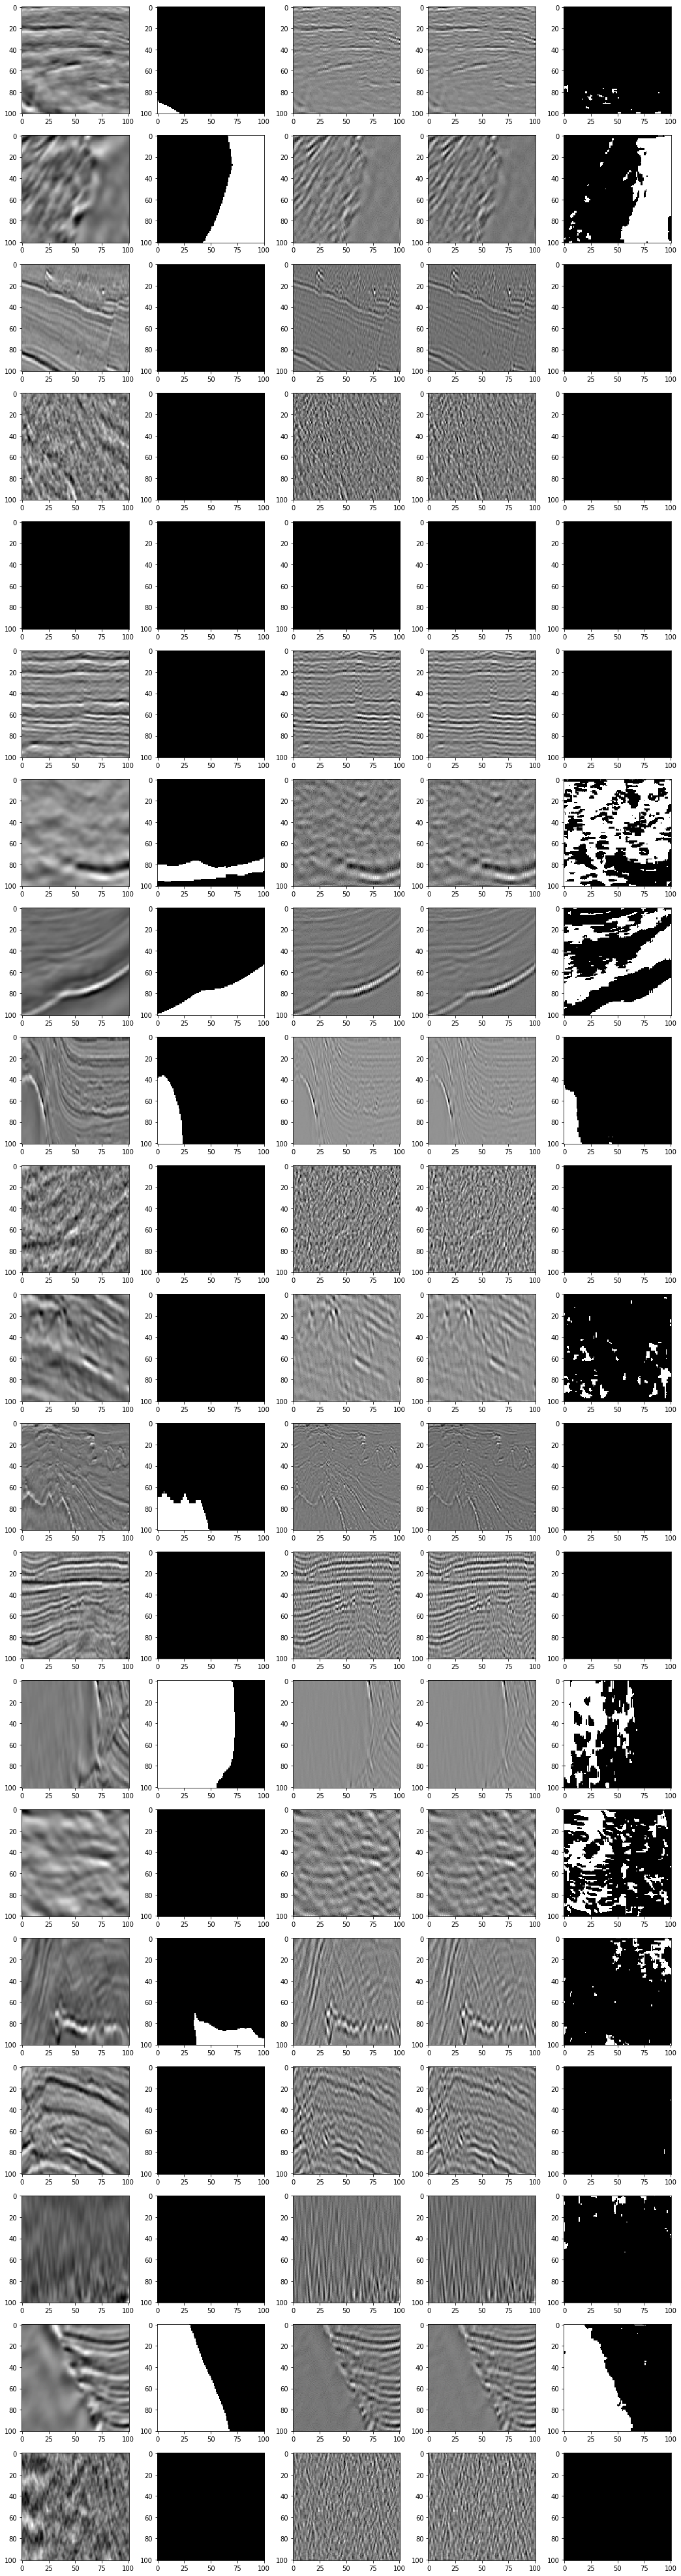

In [3]:
IMG_DIR = '/home/mothaiba/Documents/Jupyter_notebook/Salt/data/train/images/'
MASK_DIR = '/home/mothaiba/Documents/Jupyter_notebook/Salt/data/train/masks/'
list_img = [join(IMG_DIR, file) for file in listdir(IMG_DIR) if isfile(join(IMG_DIR, file))]
list_mask = [join(MASK_DIR, file) for file in listdir(MASK_DIR) if isfile(join(MASK_DIR, file))]
kernel = [[0, -1, 0], [-1, 4, -1], [0, -1, 0]]
nshow = 20
ncol = 5

fig = plt.figure(figsize=(18, 18*nshow/5))
for idx in range(nshow):
    path_img = list_img[idx]
    path_mask = list_mask[idx]
    
    img = ndimage.imread(path_img, flatten=True)
    fig.add_subplot(nshow, ncol, idx*ncol+1)
    plt.imshow(img, cmap='gray')
    
    mask = ndimage.imread(path_mask)
    fig.add_subplot(nshow, ncol, idx*ncol+2)
    plt.imshow(mask, cmap='gray')
    
    colv = ndimage.convolve(img, kernel)
    fig.add_subplot(nshow, ncol, idx*ncol+3)
    plt.imshow(colv, cmap='gray')
    
    img = img - ndimage.uniform_filter(img, mode='nearest')
    fig.add_subplot(nshow, ncol, idx*ncol+4)
    plt.imshow(img, cmap='gray')
    
    win_mean = ndimage.uniform_filter(img, size=5, mode='nearest')
    win_mean2 = ndimage.uniform_filter(img**2, size=5, mode='nearest')
    win_var = win_mean2 - win_mean**2
    fig.add_subplot(nshow, ncol, idx*ncol+5)
    plt.imshow((win_var)<1., cmap='gray')
    
    
    

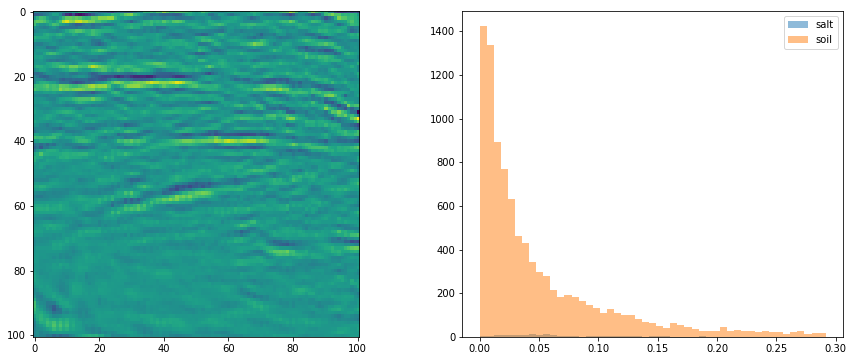

depth: 217


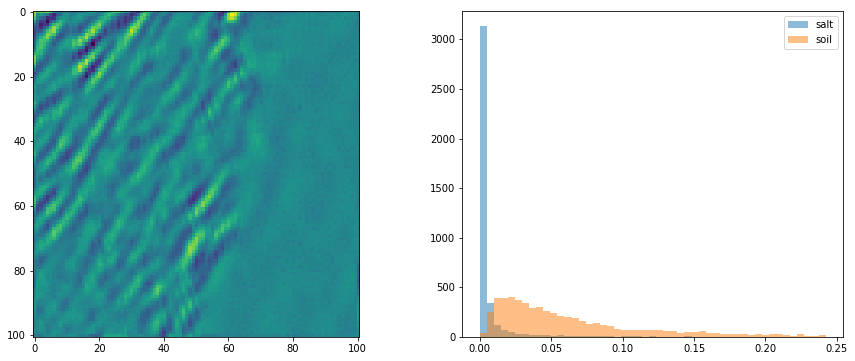

depth: 531


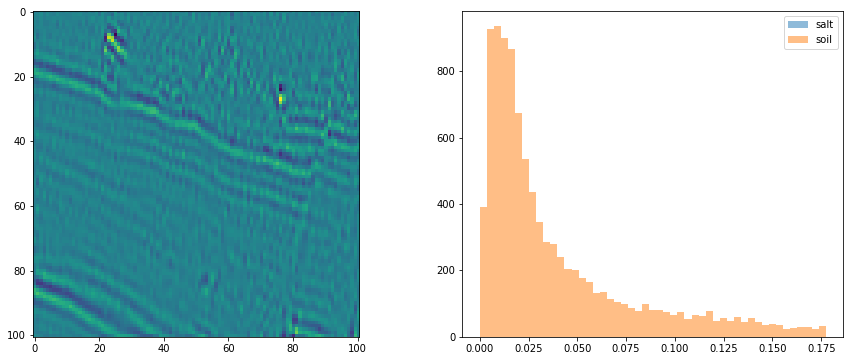

depth: 302


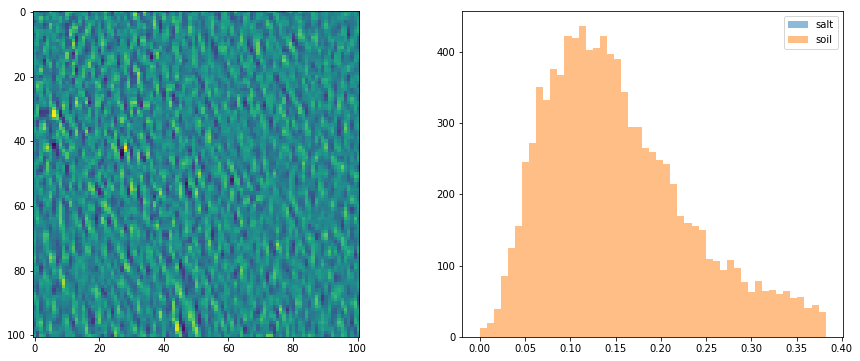

depth: 135


/home/mothaiba/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/mothaiba/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


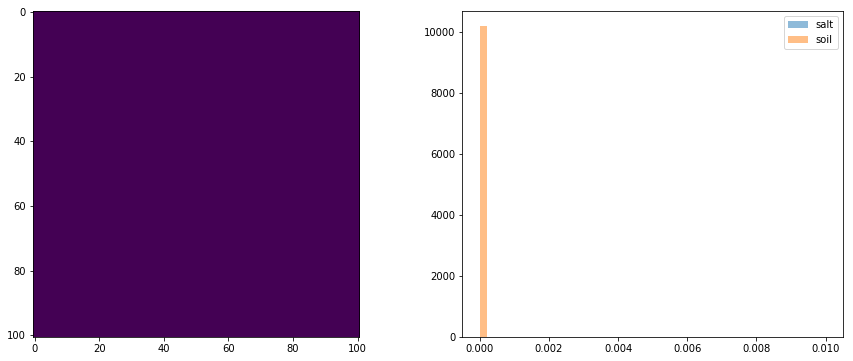

depth: 100


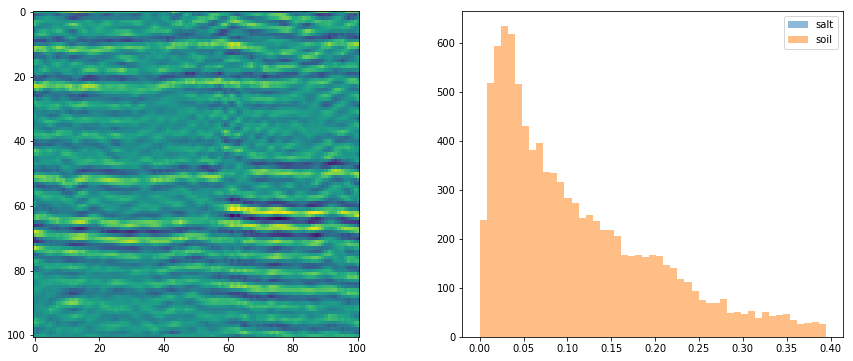

depth: 273


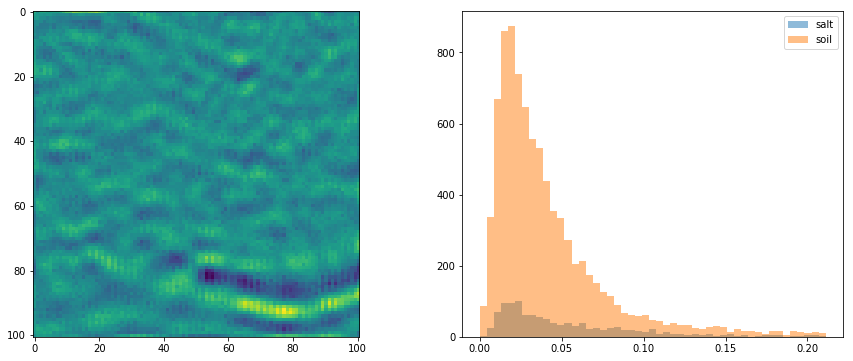

depth: 505


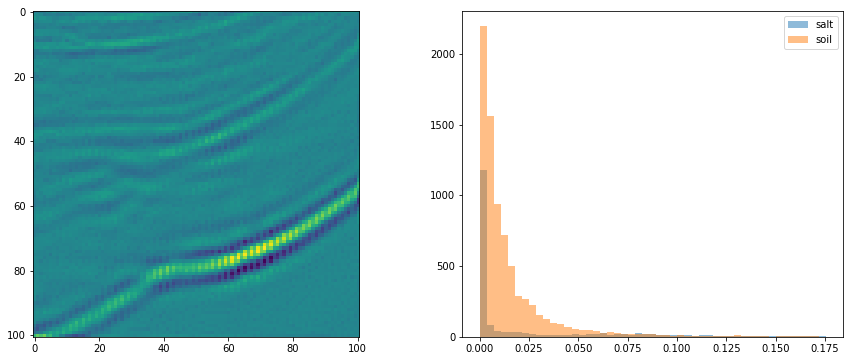

depth: 429


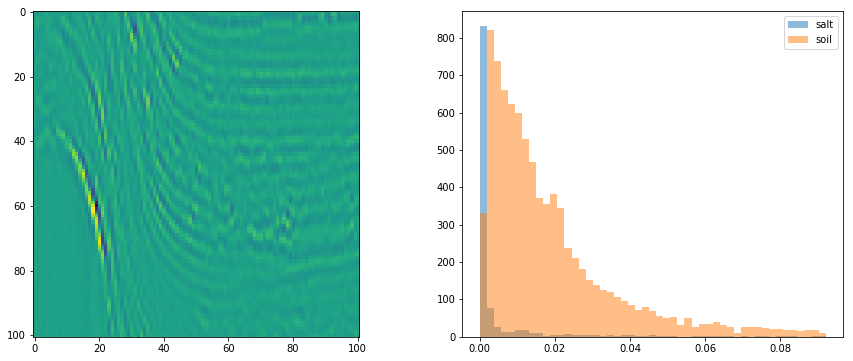

depth: 438


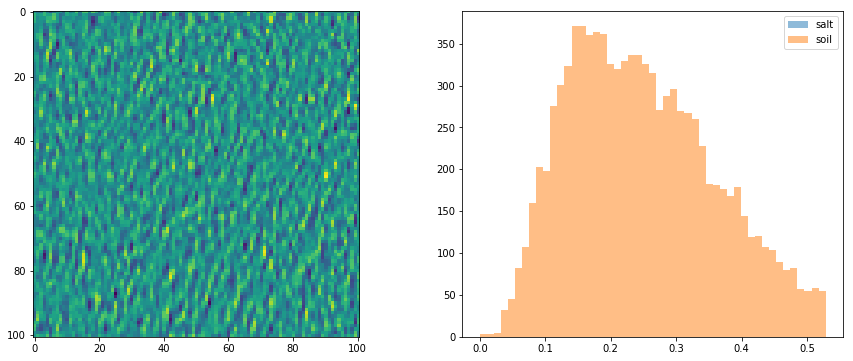

depth: 410


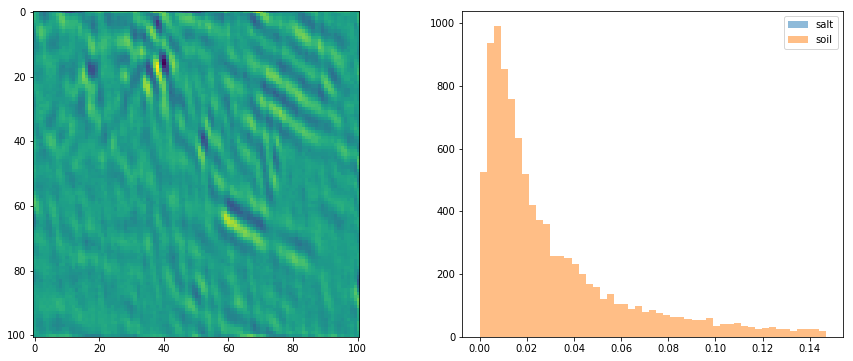

depth: 739


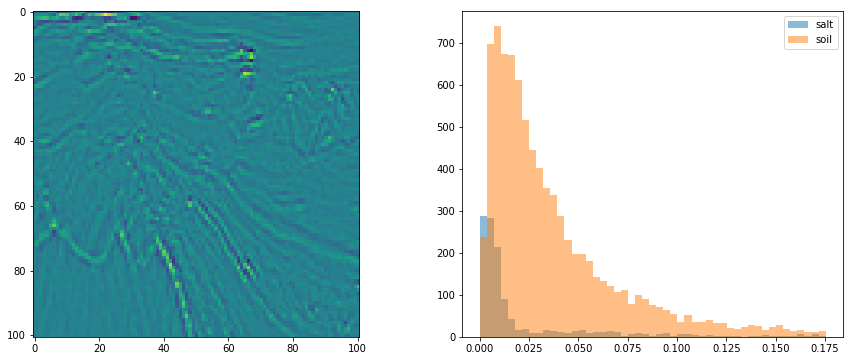

depth: 835


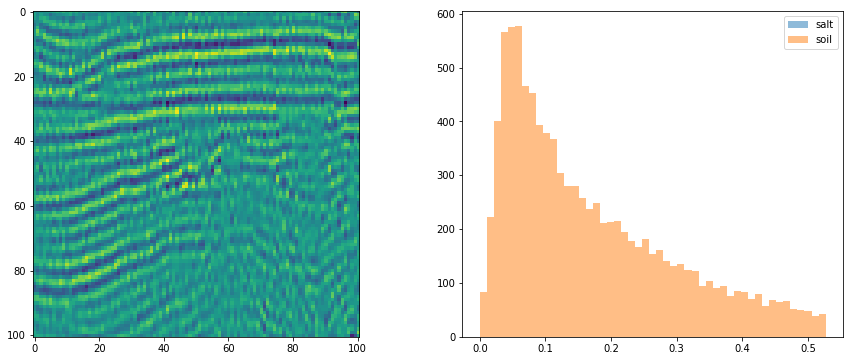

depth: 303


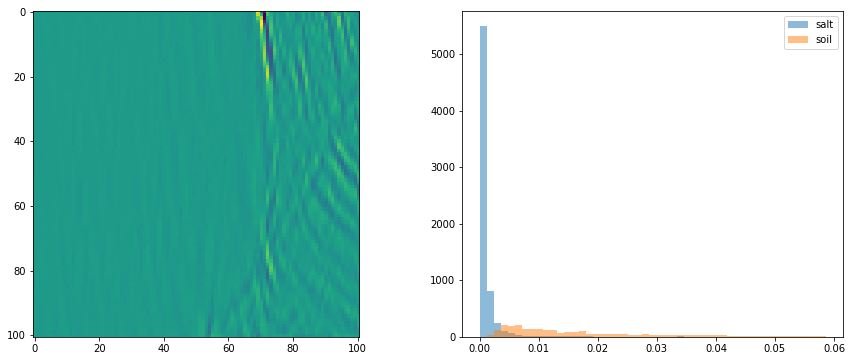

depth: 489


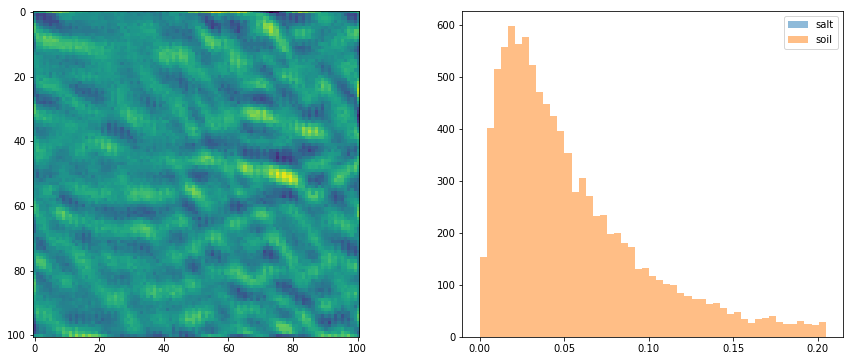

depth: 793


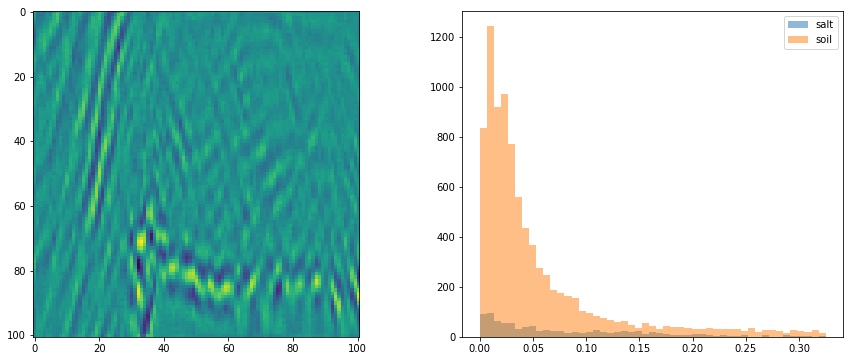

depth: 818


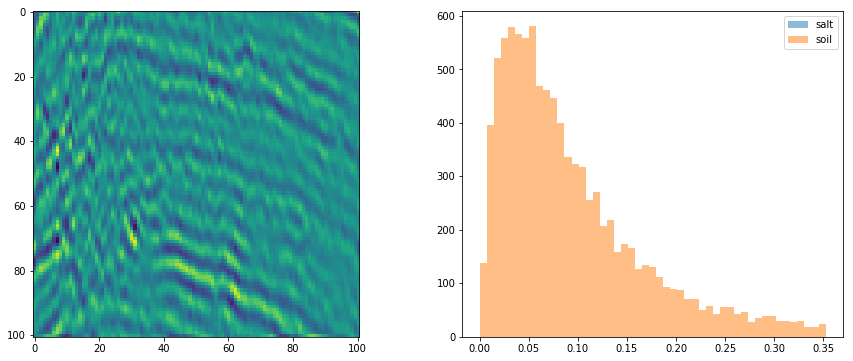

depth: 782


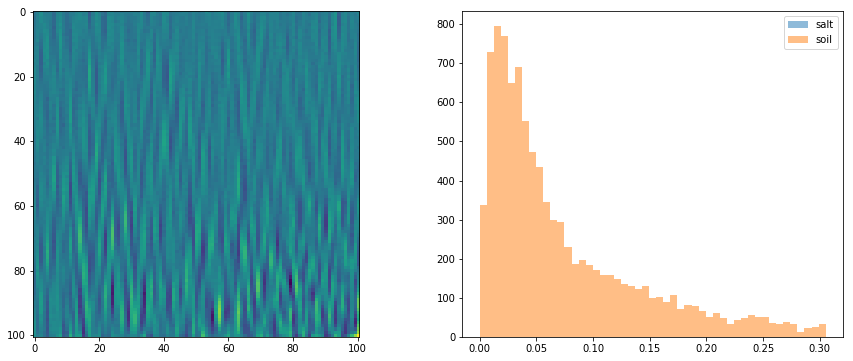

depth: 576


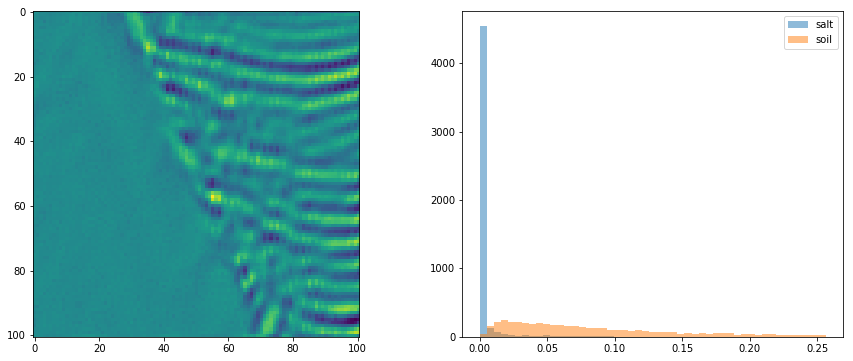

depth: 466


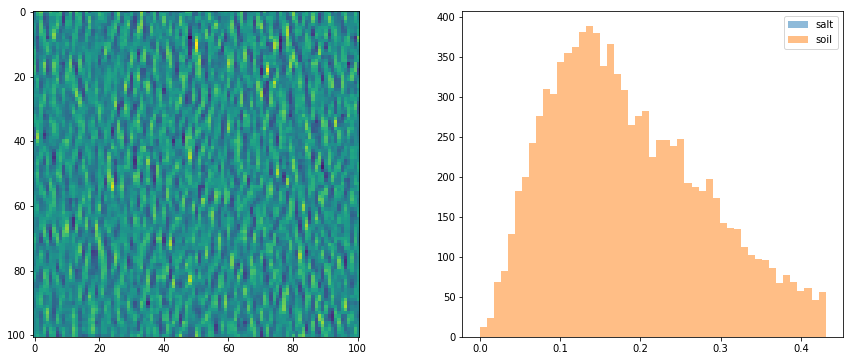

depth: 710


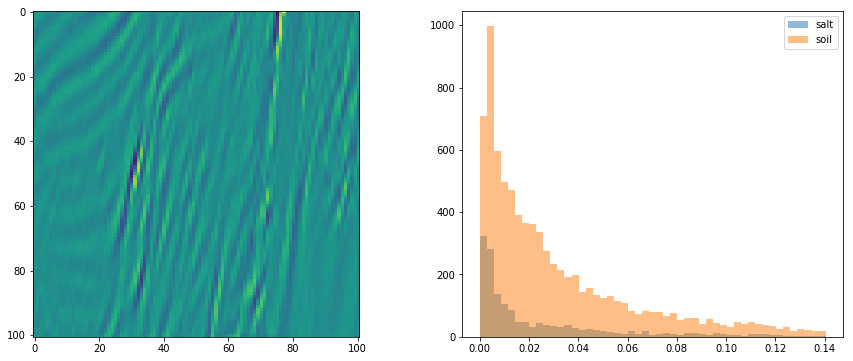

depth: 754


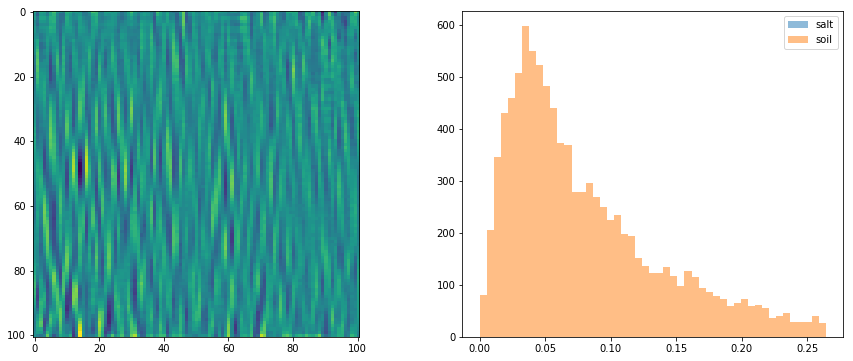

depth: 524


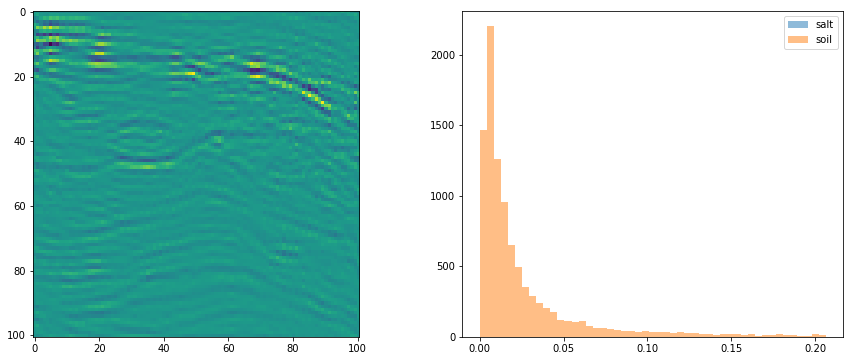

depth: 157


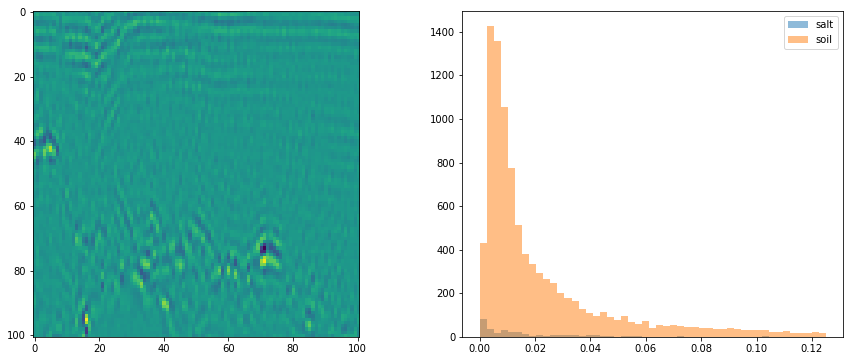

depth: 248


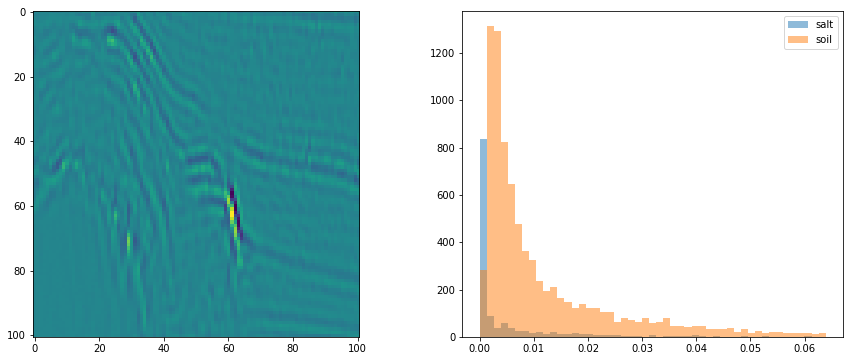

depth: 484


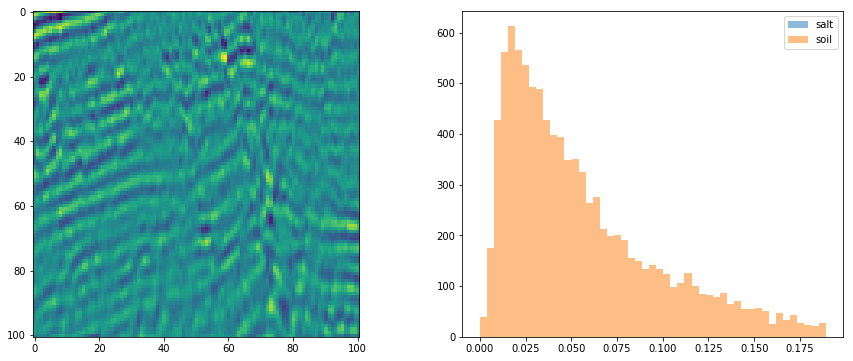

depth: 592


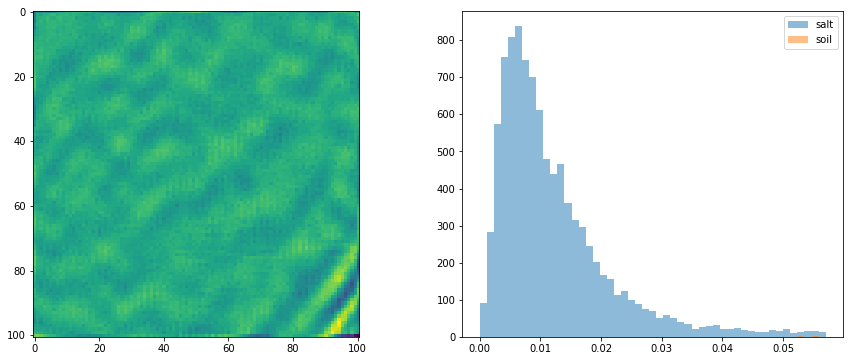

depth: 681


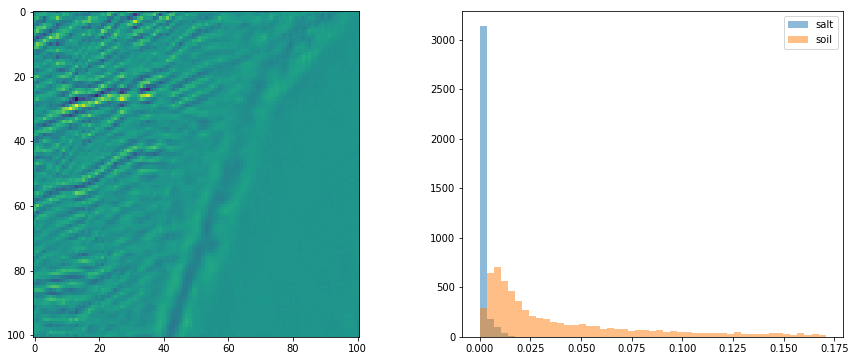

depth: 234


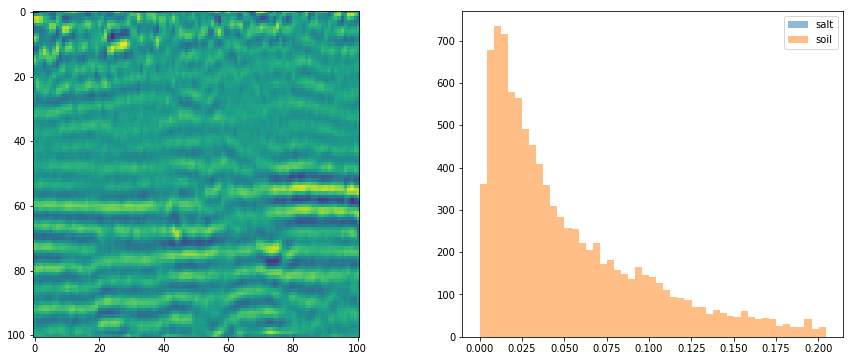

depth: 709


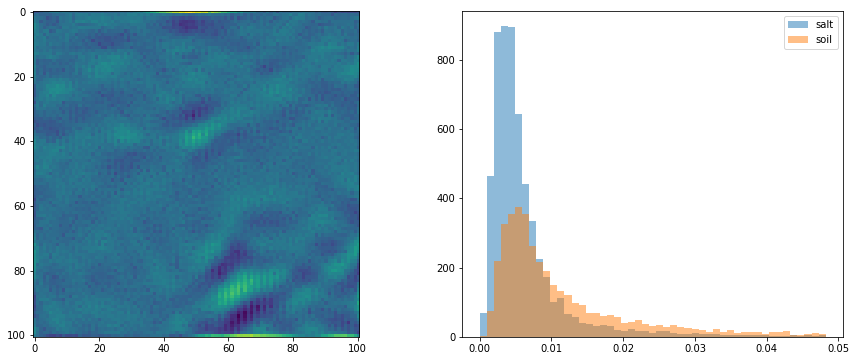

depth: 829


In [26]:

for idx in range(0, 30):
    img = ndimage.imread(list_img[idx], flatten=True)
    img = img - ndimage.uniform_filter(img, mode='nearest')
    win_mean = ndimage.uniform_filter(img, size=5, mode='nearest')
    win_mean2 = ndimage.uniform_filter(img**2, size=5, mode='nearest')
    win_var = win_mean2 - win_mean**2
    win_var = win_var - win_var.min()
    win_var = win_var / win_var.max()

    mask = ndimage.imread(list_mask[idx])

    salt_masked = np.ma.masked_where(mask == 0, win_var).compressed()
    salt_masked = np.nan_to_num(salt_masked)
    
    soil_masked = np.ma.masked_where(mask > 0, win_var).compressed()
    soil_masked = np.nan_to_num(soil_masked)
    
    fig = plt.figure(figsize=(15, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    
    max_val = np.percentile(win_var, 95)
    if np.isnan(max_val):
        max_val = 0.01
    bins = np.linspace(0., max_val, 50)
    fig.add_subplot(1, 2, 2)
    plt.hist(salt_masked, bins = bins, alpha=0.5, label='salt')
#     print ('soil_masked: {}'.format(str(soil_masked)))
#     print ('bins: {}'.format(str(bins)))
    plt.hist(soil_masked, bins = bins, alpha=0.5, label='soil')
    plt.legend(loc='upper right')
    plt.show()
    
    img_name = list_img[idx][list_img[idx].rfind('/')+1:len(list_img[idx])-4]
    d = depth[depth['id'] == img_name].z.tolist()[0]
    print ('depth: {}'.format(d))

### get ground_true and pred (simple win_var)

In [47]:
simple_pred = []
ground_true = []

for idx in range(len(list_img)):
    img = ndimage.imread(list_img[idx], flatten=True)
    img = img - ndimage.uniform_filter(img, mode='nearest')
    win_mean = ndimage.uniform_filter(img, size=5, mode='nearest')
    win_mean2 = ndimage.uniform_filter(img**2, size=5, mode='nearest')
    win_var = win_mean2 - win_mean**2
    simple_pred.append(win_var)

    path_mask = list_mask[idx]
    mask = ndimage.imread(path_mask)    
    ground_true.append(mask)

### baseline score: pred = simple win_var

In [48]:
pred = [each < 1 for each in simple_pred]
print('baseline score: {}'.format(round(TAux.iou_score(ground_true, pred), 3)))

baseline score: 0.289


### grid search for best threshold

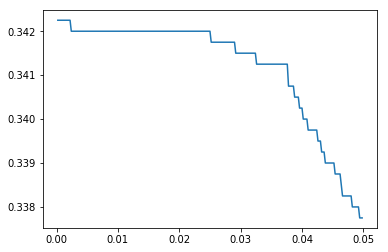

Best NO-NORM threshold: 0.0022 with score 0.34225


/home/mothaiba/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/mothaiba/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less


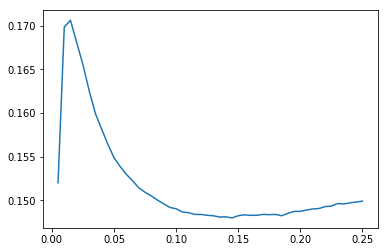

Best NORM threshold: 0.015 with score 0.17064999999999997


In [79]:
# DO NOT use normalization
nonorm_score = {}
for thres in np.arange(0.0002, 0.05, 0.0002):
    pred = [each < thres for each in simple_pred]
    score = TAux.iou_score(ground_true, pred)
    nonorm_score[thres] = score
#     print('NO-NORM threshold({}) score: {}'.format(round(thres, 1), round(score, 4)))

values = [nonorm_score[key] for key in sorted(nonorm_score.keys())]
plt.plot(sorted(nonorm_score.keys()), values)
plt.show()

best_key = max(nonorm_score, key=nonorm_score.get)
print ('Best NO-NORM threshold: {} with score {}'.format(best_key, nonorm_score[best_key]))

# DO use normalization
norm_score = {}

def norm_it(inp):
    inp = inp - inp.min()
    inp = inp / inp.max()
    return inp
pred_normed = [norm_it(each) for each in simple_pred]
for thres in np.arange(0.005, 0.251, 0.5):
    pred = [each < thres for each in pred_normed]
    score = TAux.iou_score(ground_true, pred)
    norm_score[thres] = score
#     print('NORM threshold({}) score: {}'.format(round(thres, 1), round(score, 3)))

values = [norm_score[key] for key in sorted(norm_score.keys())]
plt.plot(sorted(norm_score.keys()), values)
plt.show()

best_key = max(norm_score, key=norm_score.get)
print ('Best NORM threshold: {} with score {}'.format(best_key, norm_score[best_key]))

#### best result: no-norm, threshold = 0.002